# Setup Code

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import numpy as np
import matplotlib.pyplot as plt


# General constants
data_path = "gdrive/My Drive/Dataset/"
model_path = "gdrive/My Drive/Models/4_layer_more_nodes/" # Change this depending on what model you want to run

batch_size = 32
img_width = 640
img_height = 240 * 2

# Full Dataset Processing

Load images and labels, and split into taining and testing sets.

In [0]:
import pandas as pd
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import os

def load_image(im):
    return img_to_array(load_img(im, color_mode='grayscale')) / 255.

def get_images(df):
  im_list_0 = df['FrameID'].apply(lambda x: os.path.join(data_path, "Images/" + str(x) + "_0.jpg")).tolist()
  im_list_1 = df['FrameID'].apply(lambda x: os.path.join(data_path, "Images/" + str(x) + "_1.jpg")).tolist()
  images_0 = np.array([load_image(im) for im in im_list_0])
  images_1 = np.array([load_image(im) for im in im_list_1])
  return np.concatenate((images_0, images_1), axis=1)

def get_labels(df):
  return df.values[:, 2:]

# Read in the CSV
dataCSV = pd.read_csv(data_path + "Labels.csv")

# Split for training and testing
train = dataCSV.sample(frac=0.8, random_state=1) #use fixed seed so training and test never overlap on later runs
test = dataCSV.drop(train.index)

train_images = get_images(train)
train_labels = get_labels(train)
test_images = get_images(test)
test_labels = get_labels(test)

Using TensorFlow backend.


## Create New Model

Create the model structure

In [0]:
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten, Concatenate

# Design the model
input_layer  = Input(shape=(img_height, img_width, 1))
conv1  = MaxPooling2D(pool_size=(2,2))(Conv2D(16, (3,3), activation='relu')(input_layer))
conv2  = MaxPooling2D(pool_size=(2,2))(Conv2D(32, (3,3), activation='relu')(conv1))
conv3  = MaxPooling2D(pool_size=(2,2))(Conv2D(64, (3,3), activation='relu')(conv2))
conv4  = MaxPooling2D(pool_size=(2,2))(Conv2D(128, (3,3), activation='relu')(conv3))
flat  = Flatten()(conv4)
output = Dense(18, activation='linear')(flat)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 480, 640, 1)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 478, 638, 16)      160       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 239, 319, 16)      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 237, 317, 32)      4640      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 118, 158, 32)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 116, 156, 64)      18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 58, 78, 64)        0         
__________

Train the model

Fitting the model
Train on 3159 samples, validate on 351 samples
Epoch 1/50
3159/3159 [==============================] - 20s 6ms/step - loss: 4410.0745 - mean_absolute_error: 49.5885 - mean_squared_error: 4410.0745 - val_loss: 1804.3058 - val_mean_absolute_error: 33.2184 - val_mean_squared_error: 1804.3058
Epoch 2/50
3159/3159 [==============================] - 18s 6ms/step - loss: 1331.2568 - mean_absolute_error: 27.9119 - mean_squared_error: 1331.2568 - val_loss: 1095.4494 - val_mean_absolute_error: 25.4491 - val_mean_squared_error: 1095.4494
Epoch 3/50
3159/3159 [==============================] - 18s 6ms/step - loss: 1042.0844 - mean_absolute_error: 24.8283 - mean_squared_error: 1042.0844 - val_loss: 942.8279 - val_mean_absolute_error: 24.2168 - val_mean_squared_error: 942.8279
Epoch 4/50
3159/3159 [==============================] - 18s 6ms/step - loss: 839.2531 - mean_absolute_error: 22.1932 - mean_squared_error: 839.2531 - val_loss: 692.7654 - val_mean_absolute_error: 20.6682 - va

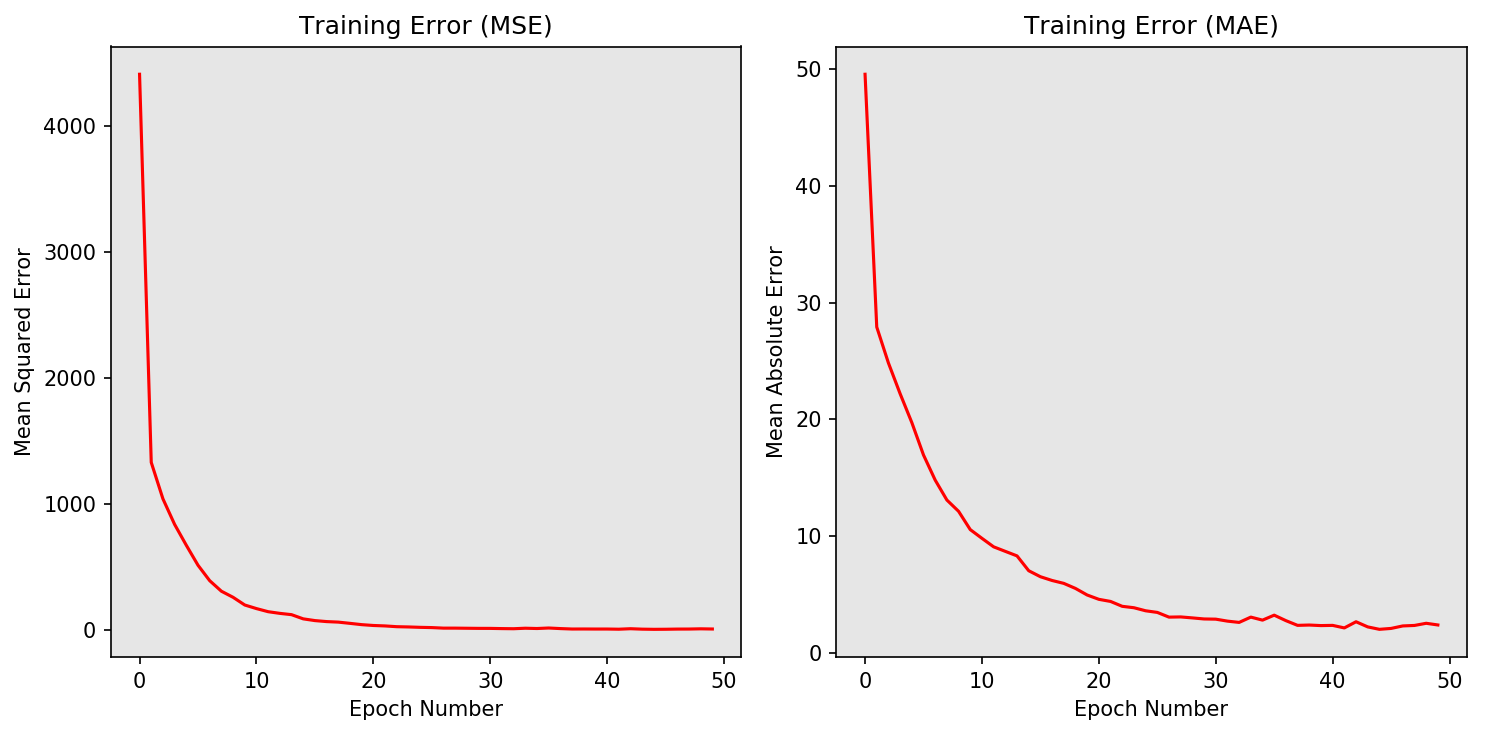

In [0]:
print("Fitting the model")

h = model.fit(train_images, train_labels, batch_size=batch_size, validation_split=0.1, shuffle=True, epochs=50, verbose=1)
model.save(model_path + "CNN_full_model.h5")

plt.figure(dpi=150, figsize=(10,5))
plt.subplot(121)
plt.plot(h.history['mean_squared_error'],  color='r')
plt.title("Training Error (MSE)")
plt.xlabel("Epoch Number")
plt.ylabel("Mean Squared Error")
plt.gca().set_facecolor((0.9, 0.9, 0.9))

plt.subplot(122)
plt.plot(h.history['mean_absolute_error'], color='r')
plt.title("Training Error (MAE)")
plt.xlabel("Epoch Number")
plt.ylabel("Mean Absolute Error")
plt.gca().set_facecolor((0.9, 0.9, 0.9))

plt.tight_layout()

plt.savefig(model_path + "CNN_training_curve.png")

## Import Existing Model

In [0]:
from keras.models import load_model

# load the entire model from file
model = load_model(model_path + "CNN_full_model.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 480, 640, 1)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 478, 638, 16)      160       
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 239, 319, 16)      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 237, 317, 32)      4640      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 118, 158, 32)      0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 116, 156, 64)      18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 58, 78, 64)        0         
__________

In [0]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file=model_path + 'model.png')

# Error Evaluation

## Testing & Prediction

Run a standard model evaluation.

In [0]:
print("Evaluating the model")
print(model.evaluate(test_images, test_labels, batch_size=batch_size, verbose=1))
print("Evaluation Complete!")

Evaluating the model
877/877 [==============================] - 2s 3ms/step
[10.157164376844975, 2.234541634469375, 10.157164376844975]
Evaluation Complete!


Run a set of predictions, and save the reuslts to CSV.

In [0]:
print("Predicting")
test_predictions = model.predict(test_images, verbose=1)
point_error = np.subtract(test_predictions, test_labels)
csv_array = np.concatenate((test.values, point_error), axis=1)
np.savetxt(model_path + "CNN_Prediction_Errors.csv", csv_array, fmt="%f", delimiter=",")
print("File Saved!")

Predicting
877/877 [==============================] - 2s 3ms/step
File Saved!


## Plot histograms

Import the model's error csv file.

In [0]:
csv_array = np.genfromtxt(model_path + "CNN_Prediction_Errors.csv", delimiter=',')
print("CSV Data Imported!")

CSV Data Imported!


Net Error Over All Points

Mean: 0.234
Standard Deviation: 3.18


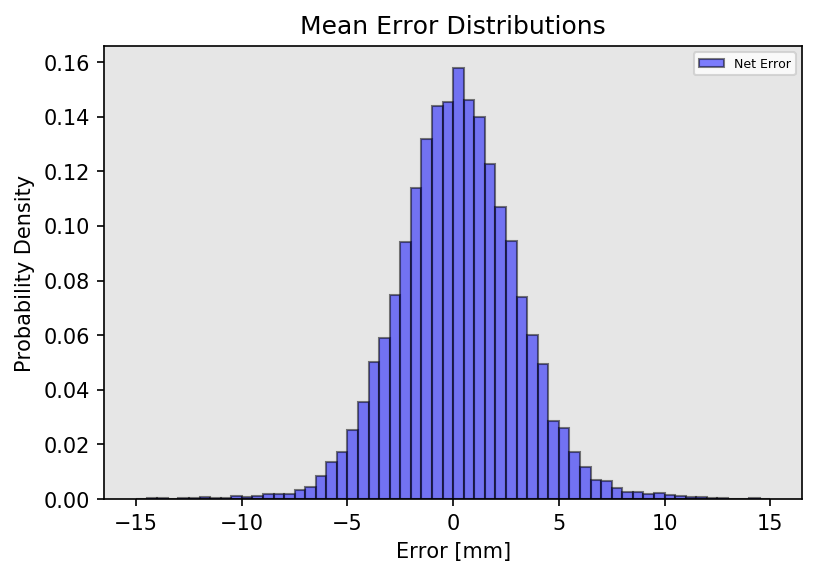

In [0]:
# CSV Structure
# FrameID, Hand, Positions, Errors
#    0       1      2:19     20:

#error for each frame
error = csv_array[:, 20:].flatten()


plt.figure(dpi=150)

# Plotting Parameters
a = 0.5
x_range = (-15,15)
edge = 'k'

plt.hist(error, 60, range=x_range, density=True, edgecolor=edge, alpha=a, color='b', label="Net Error");

ax = plt.gca()
ax.set_facecolor((0.9, 0.9, 0.9))
ax.set_title("Mean Error Distributions")
ax.set_xlabel("Error [mm]")
ax.set_ylabel("Probability Density")

plt.legend(fontsize=6);

# plt.savefig(model_path + "Net_Error.png")

print("Mean: {:.3g}".format(np.mean(error)))
print("Standard Deviation: {:.3g}".format(np.std(error)))

Palm vs Fingers

Mean Palm: -0.581
Standard Deviation Palm: 2.45
Mean Fingers: 0.42
Standard Deviation Fingers: 3.28


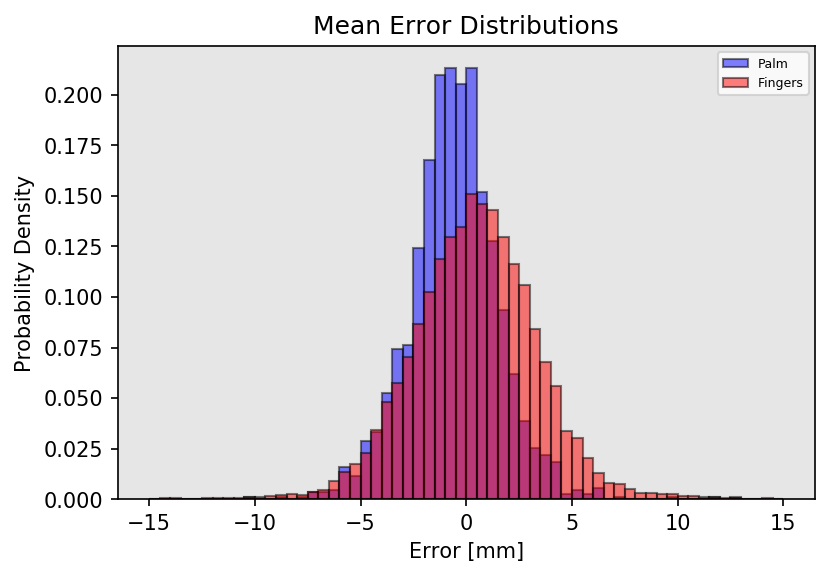

In [0]:
import matplotlib.pyplot as plt

# CSV Structure
# FrameID, Hand, Positions, Errors
#    0       1      2:19     20:


#error for each frame
error_palm    = csv_array[:, 20:22].flatten()
error_fingers = csv_array[:, 23:].flatten()

plt.figure(dpi=150)

# Plotting Parameters
a = 0.5
x_range = (-15,15)
edge = 'k'

plt.hist(error_palm,       60, range=x_range, density=True, edgecolor=edge, alpha=a, color='b', label="Palm");
plt.hist(error_fingers,    60, range=x_range, density=True, edgecolor=edge, alpha=a, color='r', label="Fingers");

ax = plt.gca()
ax.set_facecolor((0.9, 0.9, 0.9))
ax.set_title("Mean Error Distributions")
ax.set_xlabel("Error [mm]")
ax.set_ylabel("Probability Density")

plt.legend(fontsize=6)

# plt.savefig(model_path + "Palm_vs_Fingers.png")

print("Mean Palm: {:.3g}".format(np.mean(error_palm)))
print("Standard Deviation Palm: {:.3g}".format(np.std(error_palm)))
print("Mean Fingers: {:.3g}".format(np.mean(error_fingers)))
print("Standard Deviation Fingers: {:.3g}".format(np.std(error_fingers)))

X, Y, Z Error

Mean X: 1.11
Standard Deviation X: 3.46
Mean Y: -0.755
Standard Deviation Y: 2.9
Mean Z: 0.831
Standard Deviation Z: 2.77


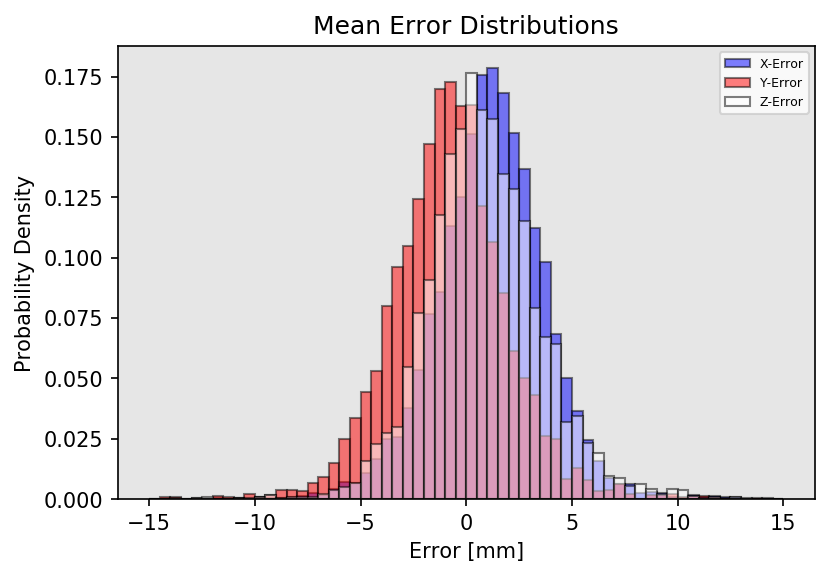

In [0]:
# CSV Structure
# FrameID, Hand, Positions, Errors
#    0       1      2:19     20:

#error for each frame
error_X   = csv_array[:, 20:-1:3].flatten()
error_Y   = csv_array[:, 21:-1:3].flatten()
error_Z   = csv_array[:, 22:-1:3].flatten()

plt.figure(dpi=150)

# Plotting Parameters
a = 0.5
x_range = (-15,15)
edge = 'k'

plt.hist(error_X,      60, range=x_range, density=True, edgecolor=edge, alpha=a, color='b', label="X-Error");
plt.hist(error_Y,      60, range=x_range, density=True, edgecolor=edge, alpha=a, color='r', label="Y-Error");
plt.hist(error_Z,      60, range=x_range, density=True, edgecolor=edge, alpha=a, color='w', label="Z-Error");

ax = plt.gca()
ax.set_facecolor((0.9, 0.9, 0.9))
ax.set_title("Mean Error Distributions")
ax.set_xlabel("Error [mm]")
ax.set_ylabel("Probability Density")

plt.legend(fontsize=6);

# plt.savefig(model_path + "XYZ_Error.png")

print("Mean X: {:.3g}".format(np.mean(error_X)))
print("Standard Deviation X: {:.3g}".format(np.std(error_X)))
print("Mean Y: {:.3g}".format(np.mean(error_Y)))
print("Standard Deviation Y: {:.3g}".format(np.std(error_Y)))
print("Mean Z: {:.3g}".format(np.mean(error_Z)))
print("Standard Deviation Z: {:.3g}".format(np.std(error_Z)))